# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import itertools
import warnings
import re
import scipy
from sklearn.compose import TransformedTargetRegressor
from sklearn import set_config
from colorama import Style, Fore
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import Ridge
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, HistGradientBoostingRegressor, BaggingRegressor
from lightgbm import LGBMRegressor
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer,mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import TweedieRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, HistGradientBoostingClassifier
import math


sns.set_theme(style = 'white', palette = 'colorblind')
pal = sns.color_palette('colorblind')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)



In [2]:
SUBMIT = True

# Data

In [3]:
train = pd.read_csv(r'../train.csv')
test = pd.read_csv(r'../test.csv',index_col='Id')
sub  = pd.read_csv(r'../sample_submission.csv')

In [4]:
print(f'{Style.BRIGHT}{Fore.YELLOW} SHAPE')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Train: {Fore.GREEN} {train.shape}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Test:  {Fore.GREEN} {test.shape}')

print(f'\n\n{Style.BRIGHT}{Fore.YELLOW} NULL VALUES')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Train: {Fore.GREEN} {train.isnull().any().any()}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Test:  {Fore.GREEN} {test.isnull().any().any()}')

print(f'\n\n{Style.BRIGHT}{Fore.YELLOW} DUPLICATES')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Train: {Fore.GREEN} {train.duplicated().any().any()}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Test:  {Fore.GREEN} {test.duplicated().any().any()}')


 SHAPE
 -> Train:  (1642, 10)
 -> Test:   (411, 9)


 NULL VALUES
 -> Train:  False
 -> Test:   False


 DUPLICATES
 -> Train:  True
 -> Test:   True


In [5]:
train.head(3)

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700


In [6]:
test.head(3)

,model,year,motor_type,running,wheel,color,type,status,motor_volume
Id,,,,,,,,,
0,kia,2020,petrol,24000 km,left,black,sedan,excellent,2.0
1,nissan,2017,petrol,85000 miles,left,white,suv,excellent,2.0
2,hyundai,2021,petrol,30000 miles,left,white,sedan,excellent,2.0


In [7]:
train.drop_duplicates(inplace=True)

# Descriptive statistics

In [8]:
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] /len(train) * 100
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
desc = pd.concat([desc,train.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(cmap='YlOrBr')\
    .bar(subset=['mean'],color='green')\
    .bar(subset=['max'],color='red')\
    .bar(subset=['min'], color='purple')

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
year,int64,1633,32,1.959584,0,0.000000,2014.789957,6.594568,1987.000000,2013.000000,2017.000000,2019.000000,2023.000000
price,int64,1633,294,18.003674,0,0.000000,15980.424985,7191.552191,462.000000,11950.000000,15750.000000,18500.000000,87000.000000
motor_volume,float64,1633,20,1.224740,0,0.000000,2.035334,0.253688,0.200000,2.000000,2.000000,2.000000,4.000000
model,object,1633,5,0.306185,0,0.000000,nan,nan,nan,nan,nan,nan,nan
motor_type,object,1633,5,0.306185,0,0.000000,nan,nan,nan,nan,nan,nan,nan
running,object,1633,643,39.375383,0,0.000000,nan,nan,nan,nan,nan,nan,nan
wheel,object,1633,1,0.061237,0,0.000000,nan,nan,nan,nan,nan,nan,nan
color,object,1633,17,1.041029,0,0.000000,nan,nan,nan,nan,nan,nan,nan
type,object,1633,7,0.428659,0,0.000000,nan,nan,nan,nan,nan,nan,nan
status,object,1633,5,0.306185,0,0.000000,nan,nan,nan,nan,nan,nan,nan


In [9]:
train['running'].value_counts()

running
300000  km      19
70000  miles    18
120000  km      16
65000  miles    15
60000  miles    15
                ..
201000  km       1
8800  km         1
101  miles       1
96122  km        1
68900  miles     1
Name: count, Length: 643, dtype: int64

* running variable is not categorical, we will convert miles to km and remove the KM and miles value.

In [10]:
def miles_to_km(value):
    if 'miles' in value:
        miles = int(value.split()[0])
        km = miles * 1.60934
        return km
    elif 'km' in value:
        return int(value.split()[0])
    else:
        return None  

train['running'] = train['running'].apply(miles_to_km)
test['running'] = test['running'].apply(miles_to_km)

In [11]:
SEED = 42
TARGET = 'price'
NUMERIC_COLS = [f for f in train._get_numeric_data() if f != TARGET]
CAT_COLS = list(test.drop(NUMERIC_COLS,axis=1))

print(f'{Style.BRIGHT}{Fore.BLACK}Target         --> {Fore.GREEN}{TARGET}')
print(f'{Style.BRIGHT}{Fore.BLACK}Numeric Cols   --> {Fore.GREEN}{NUMERIC_COLS}')
print(f'{Style.BRIGHT}{Fore.BLACK}Categoric Cols --> {Fore.GREEN}{CAT_COLS}')


Target         --> price
Numeric Cols   --> ['year', 'running', 'motor_volume']
Categoric Cols --> ['model', 'motor_type', 'wheel', 'color', 'type', 'status']


# Adversarial Validation

* The purpose of adversarial validation is to check whether train and test dataset have similar distribution or not. If the validation gives ROC-AUC score of close to .5, we can say that both datasets are similar. However, if it's far from .5, both dataset have different distribution. The reason we want to do this is to make sure that we can trust our CV score, since a trusted CV only comes from dataset with similar distribution.

In [12]:
def ChangeType(df):
    for c in CAT_COLS:
        df[c] = df[c].astype('category')
    return df
ChangeTypeTransf = FunctionTransformer(ChangeType)

Xadv =  pd.concat([train, test], axis=0)
yadv = [0] * len(train) + [1] * len(test)
Xadv = Xadv.drop(TARGET,axis=1)
model = make_pipeline(ChangeTypeTransf,
                      XGBClassifier(random_state=SEED,enable_categorical=True))

cv_preds = cross_val_predict(model, Xadv, yadv, 
                             cv=5, 
                             n_jobs=-1, 
                             method='predict_proba')
score = roc_auc_score(y_true=yadv, y_score=cv_preds[:,1])
print(f"roc-auc score: {score:0.3f}")

roc-auc score: 0.503


* The result is very close to .5, therefore we can trust our CV.


# Correlation

<Axes: >

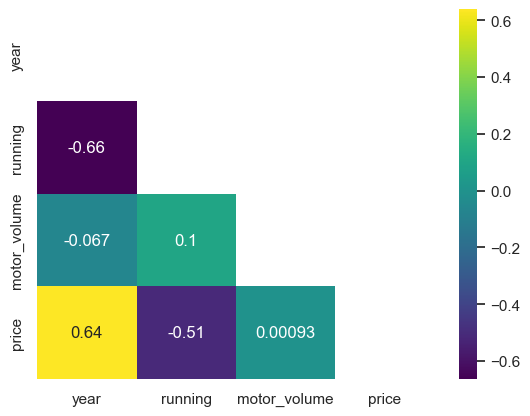

In [13]:
corr = train[NUMERIC_COLS+[TARGET]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, cmap = 'viridis', annot = True)

In [14]:
def distance(data, label = ''):
    #thanks to @sergiosaharovsky for the fix
    corr = data.corr(method = 'spearman')
    dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')
    
    plt.figure(figsize = (6,4))
    dendro = dendrogram(dist_linkage, labels=data.columns, leaf_rotation=90)
    plt.title(f'Feature Distance in {label} Dataset', weight = 'bold', size = 20)
    plt.show()

# Hierarchial Clustering

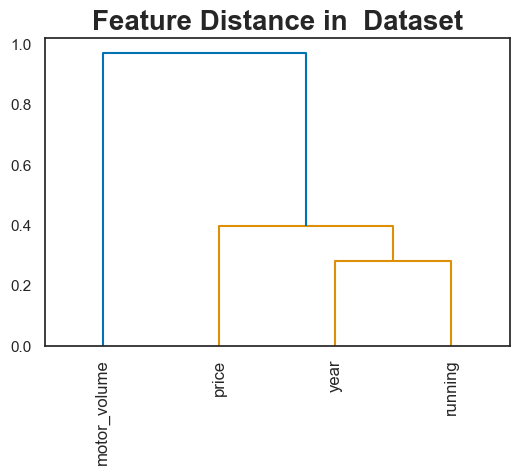

In [15]:
distance(train[NUMERIC_COLS+[TARGET]])

# EDA

##  Numeric Features

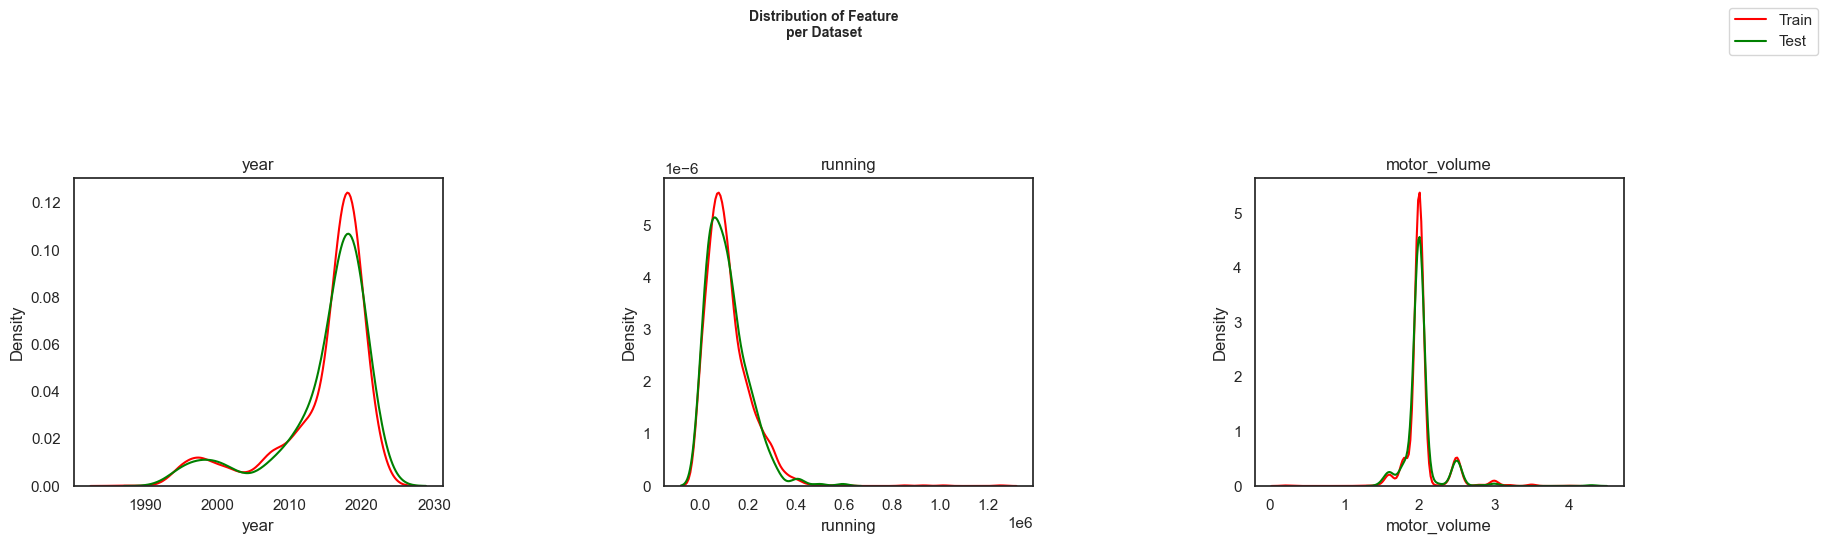

In [16]:
n_cols = 3
n_rows = math.ceil(len(NUMERIC_COLS)/n_cols)
fig, ax = plt.subplots(1,n_cols, figsize=(20,n_rows*4))
ax = ax.flatten()
plt.subplots_adjust(wspace=0.6)
for i,c in enumerate(NUMERIC_COLS):
    sns.kdeplot(train[c],color='red',ax=ax[i])
    sns.kdeplot(test[c],color='green',ax=ax[i])
    ax[i].set_title(f'{c}')
for j in range(len(NUMERIC_COLS),len(ax)):
    ax[j].axis('off')
fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize = 10 ,fontweight = 'bold',y=1.30)
fig.legend(['Train', 'Test'],loc='upper right')
plt.show()
    

# Categorical Features

In [17]:
def plot_categorical():
    fig, ax = plt.subplots(len(CAT_COLS), 2, figsize = (16, len(CAT_COLS)*6))

    for i, column in enumerate(CAT_COLS):
        ax[i][0].pie(
            train[column].value_counts(), 
            shadow = True, 
            explode = [.1 for i in range(train[column].nunique())], 
            autopct = '%1.f%%',
            textprops = {'size' : 14, 'color' : 'white'}
        )
        
        sns.countplot(x=train[column], ax=ax[i][1])
        ax[i][1].set_title(f'{column}')
        ax[i][1].set_ylabel('Count')
        ax[i][1].set_xlabel(column)
        ax[i][1].tick_params(axis='x', labelrotation=45)

        
    plt.tight_layout()
    plt.show()

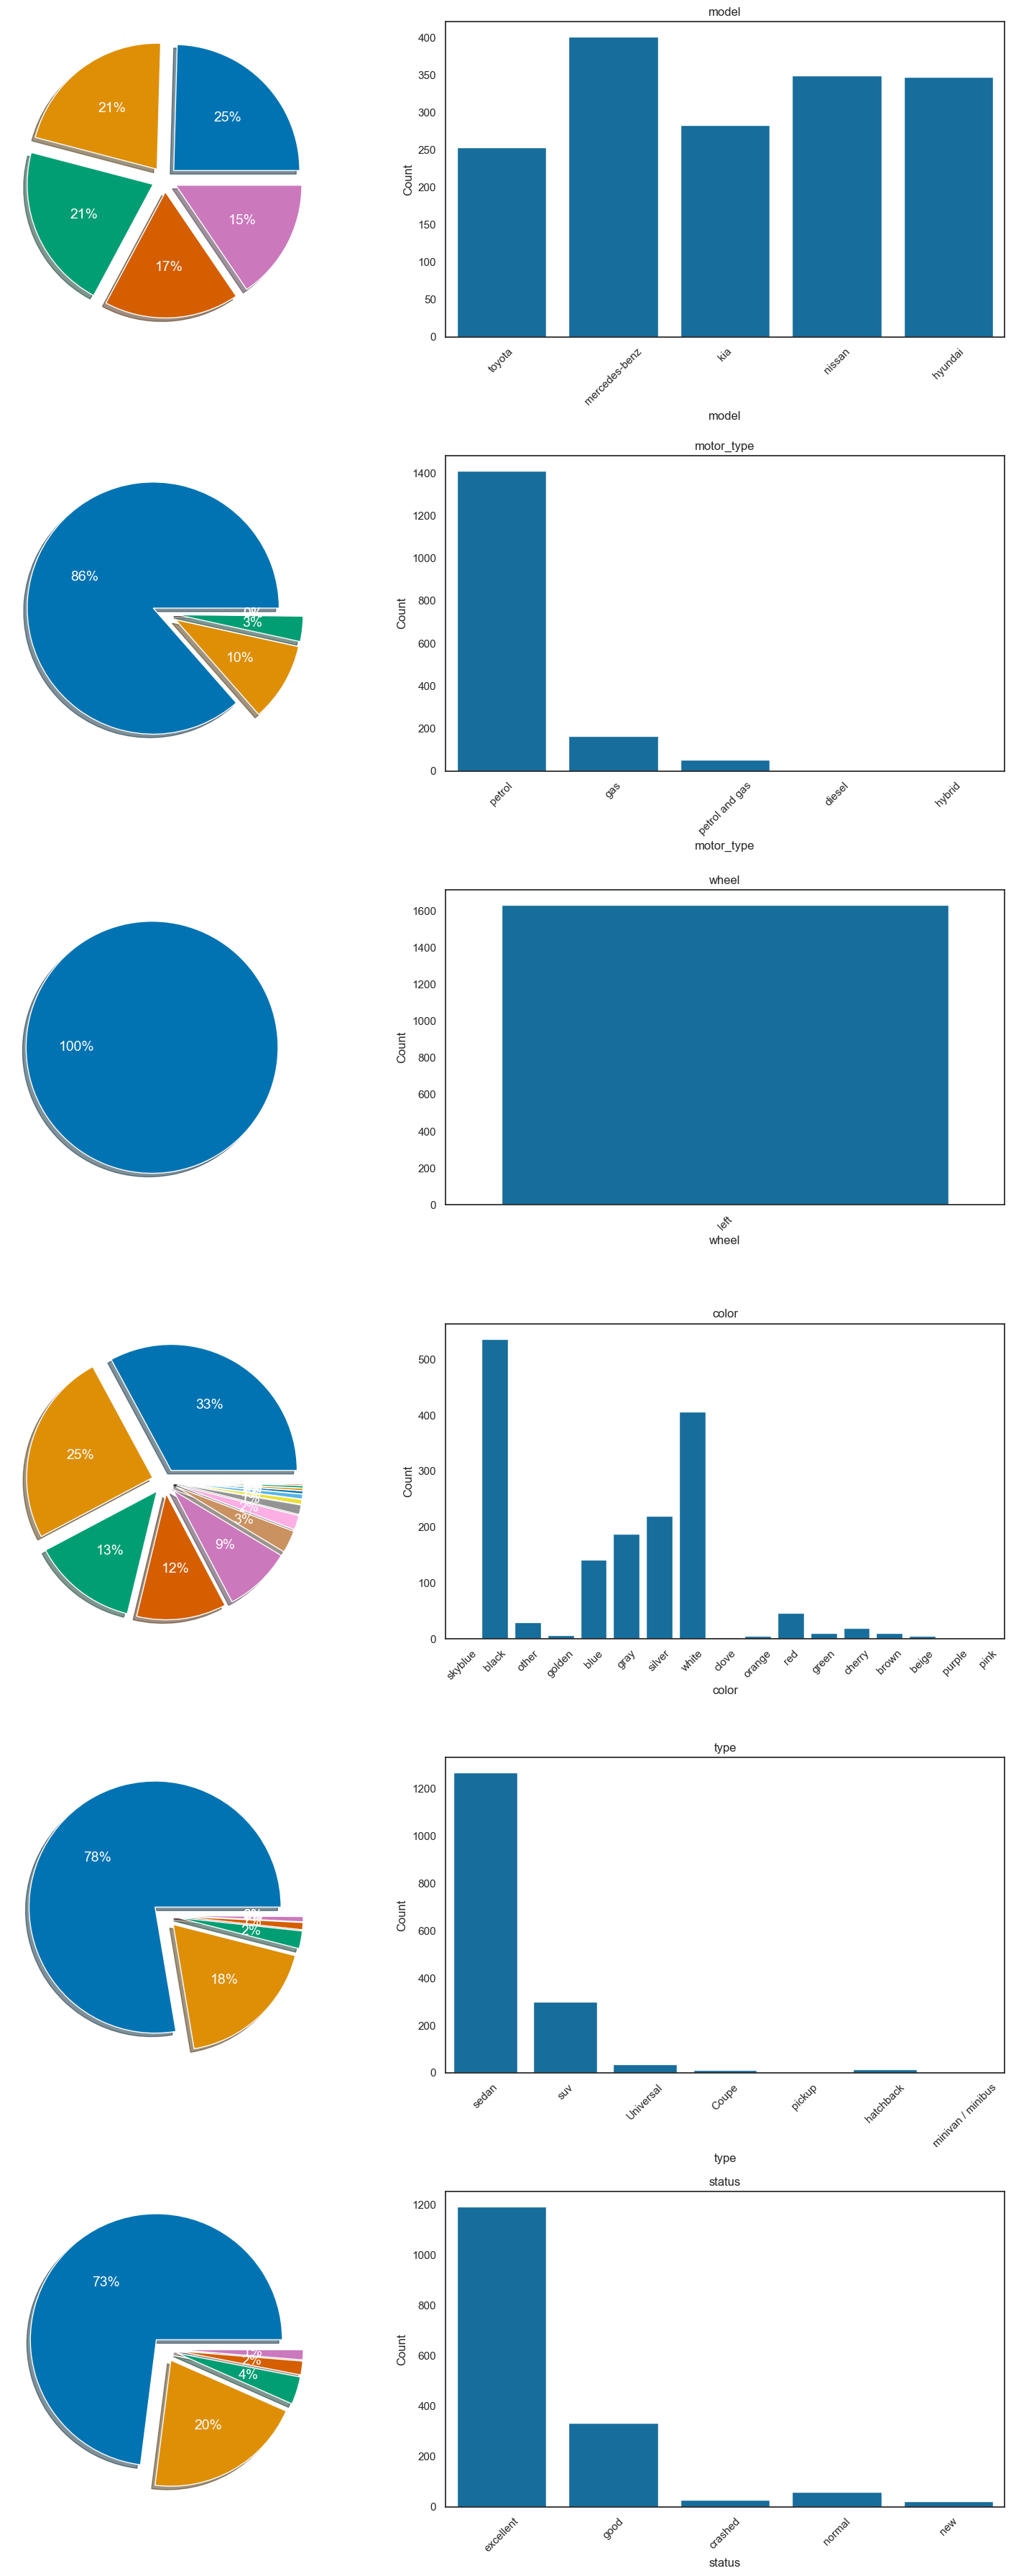

In [18]:
plot_categorical()

# Target

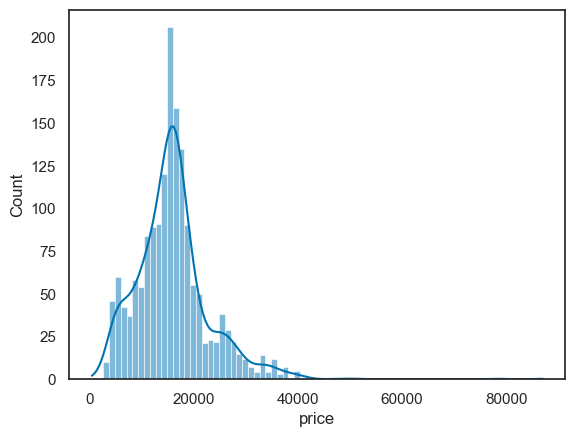

In [19]:
sns.histplot(train[TARGET],kde=True, fill=True);

In [20]:
train[TARGET].skew()

1.6931402388572612

* We have our target variable with positive skewness, so logarithmic transformation or sqrt can help us.

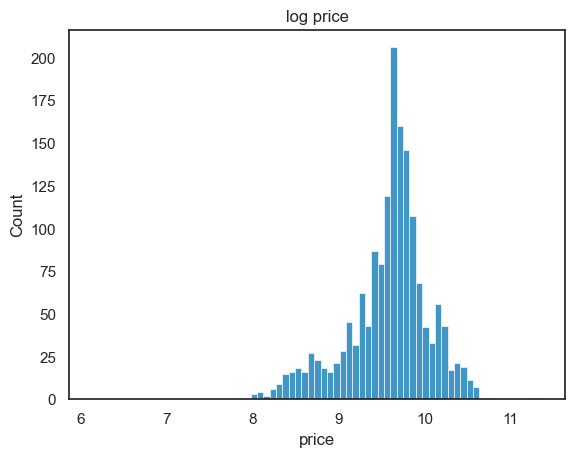

In [21]:
sns.histplot(np.log(train[TARGET]));
plt.title(f'log {TARGET}');

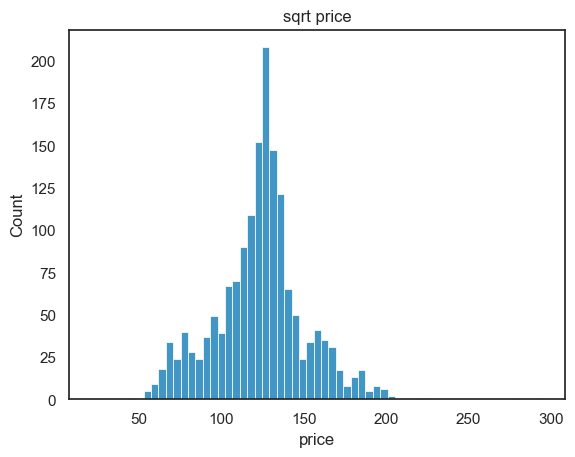

In [22]:
sns.histplot(np.sqrt(train[TARGET]));
plt.title(f'sqrt {TARGET}');

# Categorical Vs Target

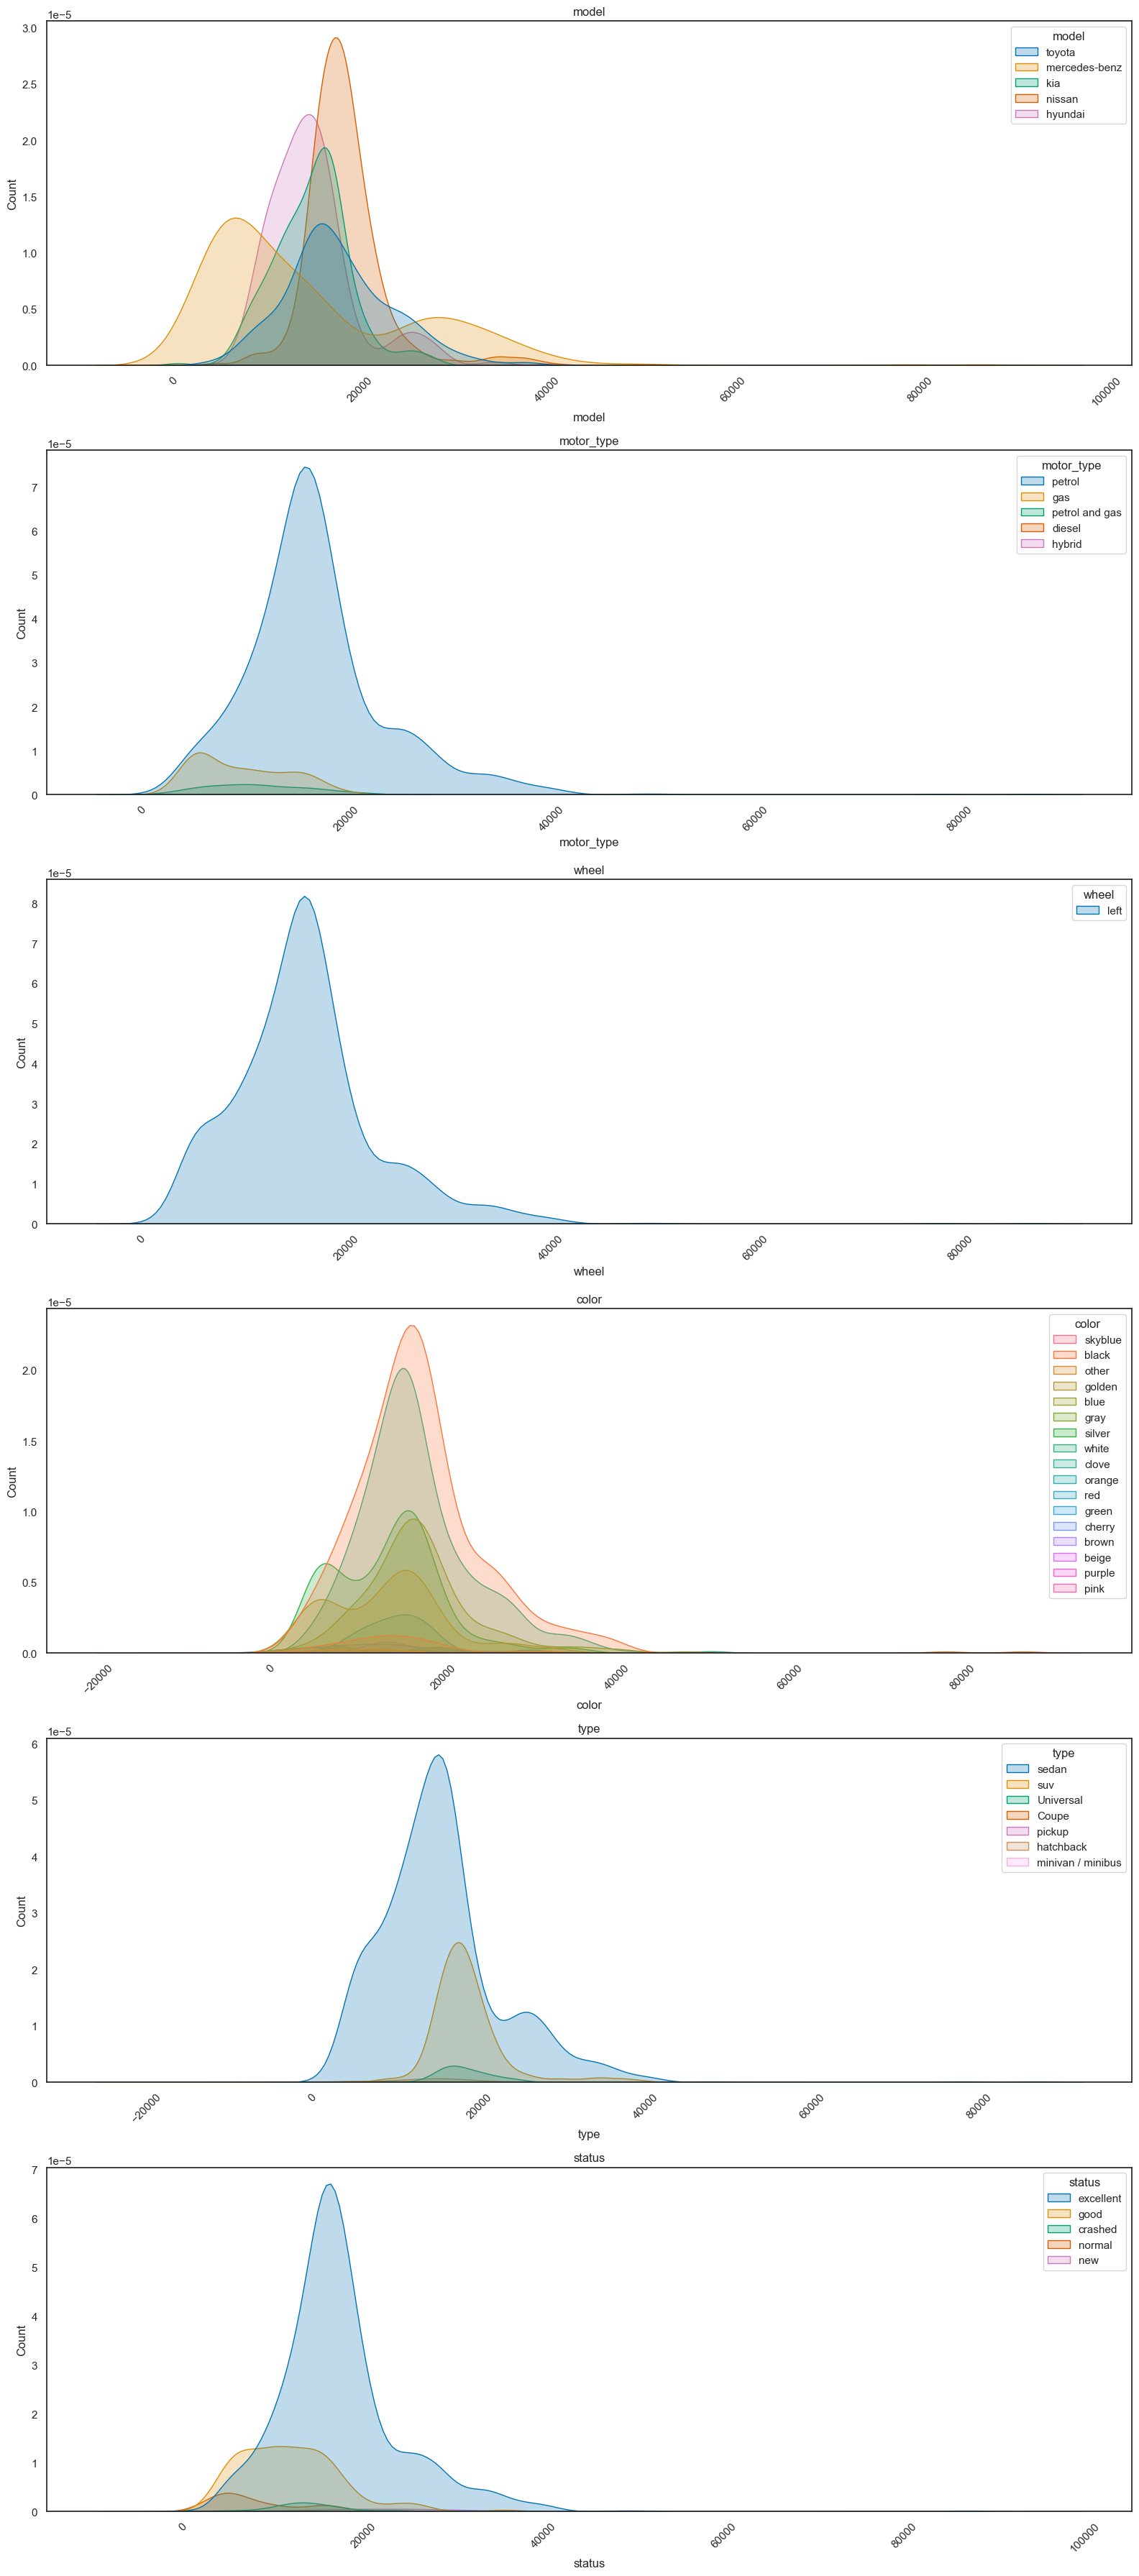

In [23]:
fig, ax = plt.subplots(len(CAT_COLS), 1, figsize = (16, len(CAT_COLS)*6))

for i, column in enumerate(CAT_COLS):      

    sns.kdeplot(x=train[TARGET], hue=train[column], ax=ax[i],warn_singular=False, shade=True)
    ax[i].set_title(f'{column}')
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel(column)
    ax[i].tick_params(axis='x', labelrotation=45)


plt.tight_layout()
plt.show()

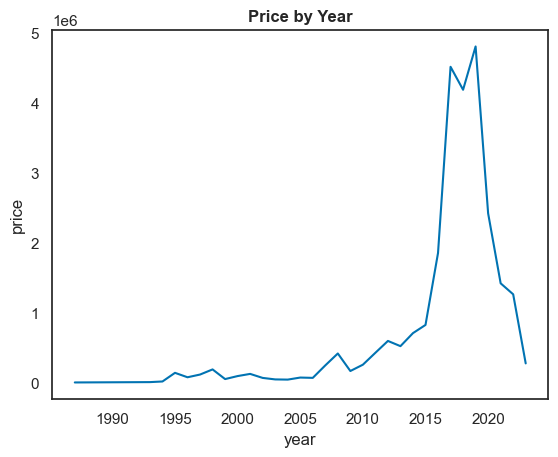

In [24]:
dftmp = train[[TARGET,'year']].groupby('year').sum().reset_index()
ax = sns.lineplot(data=dftmp,x='year',y='price',errorbar=None);
ax.set_title('Price by Year', fontweight='bold');

# Preprocess

In [25]:
class DropColsTransformer(BaseEstimator, TransformerMixin):

    def __init__(self,cols=['wheel']):
        self.cols = cols
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return X.drop(self.cols,axis=1)

In [26]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X["running_per_motor"] = X["running"] / X["motor_volume"]
        X['running_per_year'] = X['running'] / (2024-X['year'])
        
        return X

In [27]:
scores, oof, test_preds = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

In [28]:
def cross_validate(estimator, label=''):
    
    X = train.copy()
    y = X.pop(TARGET)
    
    val_predictions = np.zeros((len(X)))
    test_predictions = np.zeros((len(test)))
    train_scores, val_scores= [], []    
    
    kf = KFold(n_splits=20,shuffle=True,random_state=SEED)
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    
        model = clone(estimator)

        X_train = X.iloc[train_idx].reset_index(drop = True)
        y_train = y.iloc[train_idx].reset_index(drop = True)

        X_val = X.iloc[val_idx].reset_index(drop = True)
        y_val = y.iloc[val_idx].reset_index(drop = True)
       
        model.fit(X_train, y_train)                  
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
            
        val_predictions[val_idx] += val_preds
        test_predictions += model.predict(test) / kf.get_n_splits()
        
        train_score = mean_absolute_error(y_train, train_preds)
        val_score = mean_absolute_error(y_val, val_preds)

        train_scores.append(train_score)
        val_scores.append(val_score)
        
    print(f'Val Score: {Style.BRIGHT}{Fore.GREEN}{np.mean(val_scores):.5f} ± {np.std(val_scores):.5f}{Fore.RESET} Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')

    return val_scores, val_predictions, test_predictions

# Models

In [29]:
params_xgb = {'booster': 'gbtree',
          'max_depth': 3,
          'max_leaves': 769,
          'learning_rate': 0.04538451353216046,
          'n_estimators': 1171,
          'min_child_weight': 13,
          'subsample': 0.6578720167306904,
          'reg_alpha': 0.4622943878867952,
          'reg_lambda': 0.6211309481623339,
          'colsample_bylevel': 0.7985625445322192,
          'colsample_bytree': 0.9634723040072963,
          'colsample_bynode': 0.49814271378837316,         
          'objective': 'reg:absoluteerror',
          'n_jobs': -1,
          'random_state':SEED
         }
scores['XGB'],oof['XGB'],test_preds['XGB'] = cross_validate(
                                       make_pipeline(                                        
                                       MEstimateEncoder(cols=CAT_COLS),
                                       DropColsTransformer(),
                                       TransformedTargetRegressor(
                                               XGBRegressor(**params_xgb),                                                                                                                                       
                                               func=np.log1p,
                                               inverse_func=np.expm1)),'XGB')

/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:271: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(
/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:271: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(
/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:271: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(
/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:271: UserWarning: When `se

Val Score: 1925.83085 ± 371.79853 Train Score: 1652.64738 ± 25.92698 | XGB


In [30]:
scores['CatBoost'],oof['CatBoost'],test_preds['CatBoost'] = cross_validate(make_pipeline(                                       
                                       TransformedTargetRegressor(CatBoostRegressor(
                                                         loss_function='MAE',
                                                         verbose = 0,
                                                         iterations = 1200,
                                                         random_state=SEED,
                                                         cat_features=CAT_COLS)
                                                         ,func=np.log1p,
                                                          inverse_func=np.expm1)),'CatBoost')

/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:271: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(
/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:271: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(
/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:271: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(
/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:271: UserWarning: When `se

Val Score: 1914.15178 ± 353.76949 Train Score: 1606.27234 ± 21.96656 | CatBoost


In [31]:
w = [0.65,0.35]
scores['CatBoost+XGB'] = mean_absolute_error(train[TARGET],oof[['CatBoost','XGB']] @ w)

# Score Models

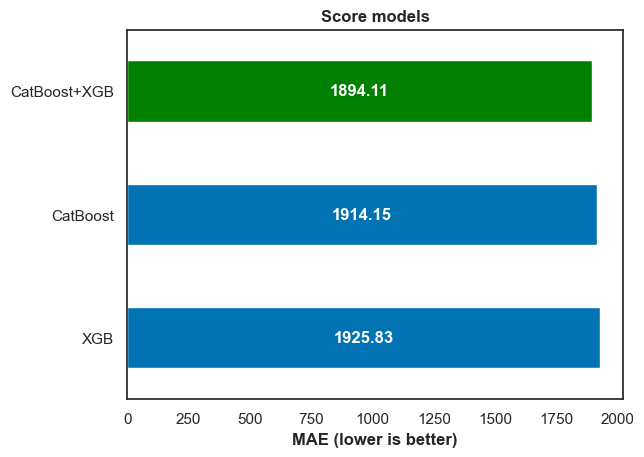

In [32]:
ax = scores.mean().sort_values(ascending=False).plot(kind='barh')
ax.bar_label(ax.containers[0],label_type ='center',color='white',fontweight='bold');
ax.patches[-1].set_facecolor('green');
ax.set_title('Score models',fontweight='bold');
ax.set_xlabel('MAE (lower is better)',fontweight='bold');

# Model performance

In [33]:
df_res = pd.DataFrame()
df_res['y_true'] = train[TARGET]
df_res['y_pred'] = oof.values @ w
df_res['error'] = df_res['y_true']-df_res['y_pred']

In [34]:
def plot_error():
    n_cols = 1
    n_rows = math.ceil(df_res.shape[1]-1/n_cols)
    fig, ax = plt.subplots(n_rows,n_cols, figsize=(20,n_rows*6))
    ax = ax.flatten()

    sns.scatterplot(x='y_pred', y='error', data=df_res,ax=ax[0])
    sns.histplot(df_res['error'],kde=True,ax=ax[1])

    for j in range(df_res.shape[1]-1,len(ax)):
        ax[j].axis('off')

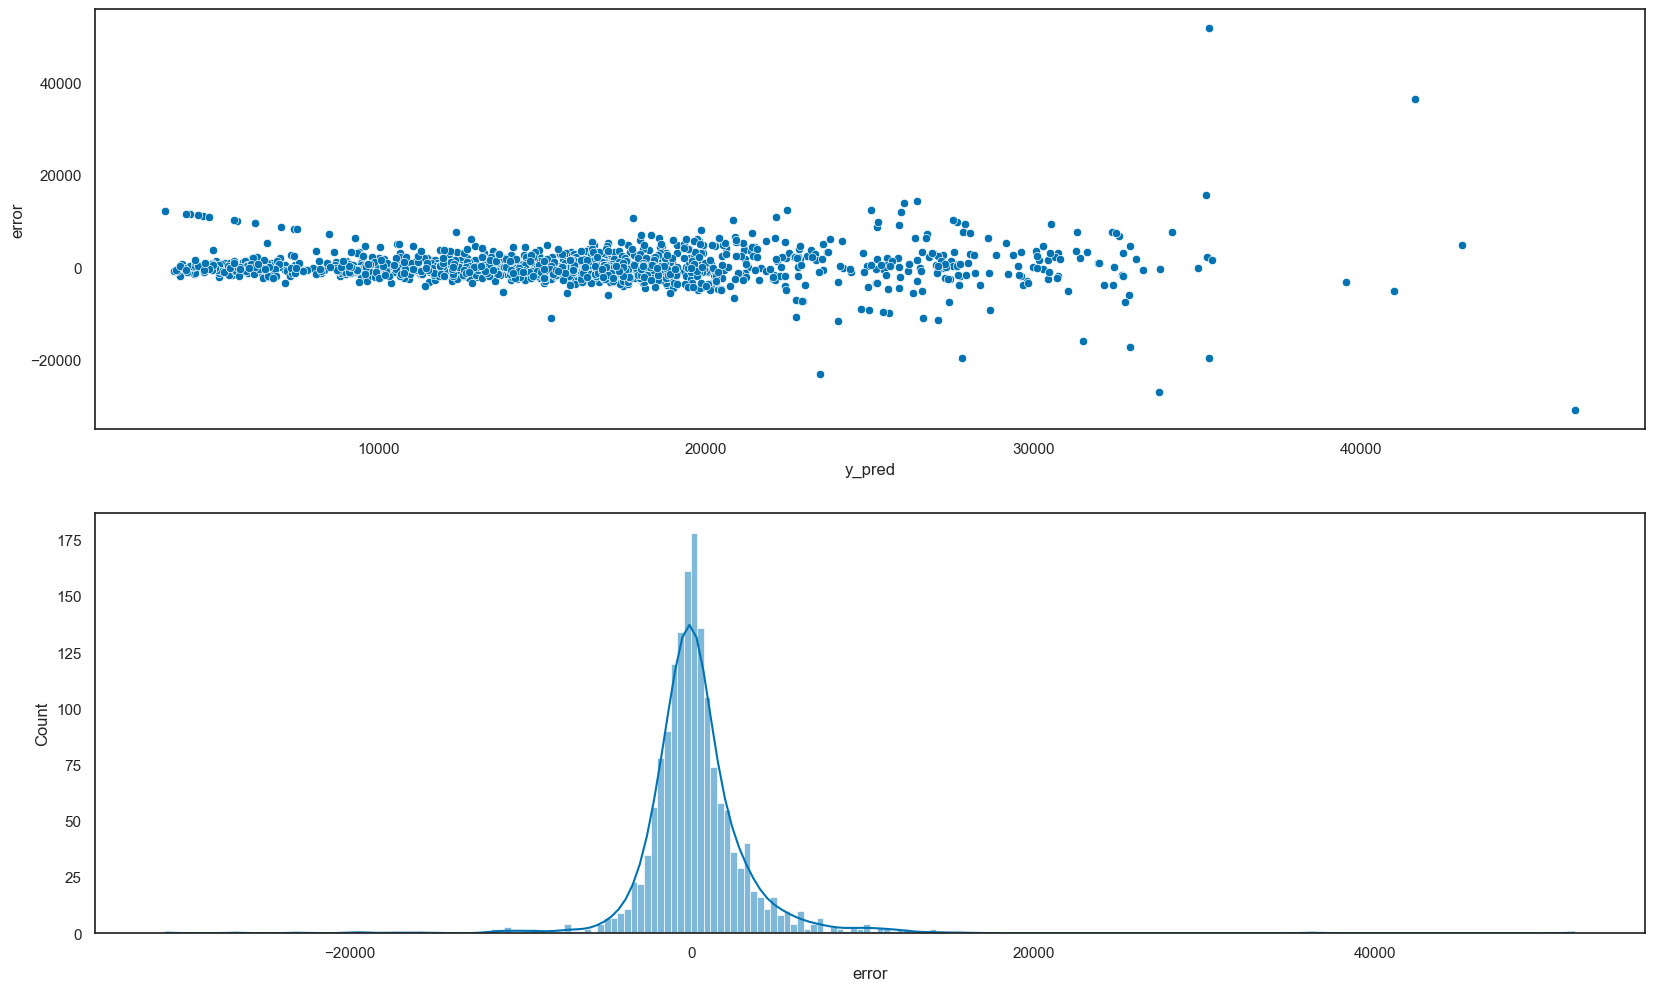

In [35]:
plot_error()

* The histogram, the error distribution, follows almost a normal distribution.

* Looking at the error scatterplot, the points appear to fit tightly into a horizontal tube, which means there is some variation in the error. If the points formed any other shape (e.g. opening/closing cone or arc), it would mean that the errors follow a trend and we would need to revise our model.

# Submission

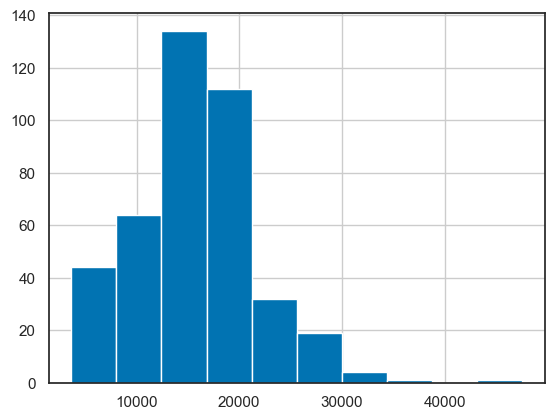

In [36]:
if SUBMIT:        
    sub['price'] = test_preds @ w
    sub['price'].hist()
    sub.to_csv('submission.csv',index=False)